In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import scipy.io as sio
from scipy.interpolate import griddata
import copy


---
# VIDEO: Outliers via standard deviation threshold
---


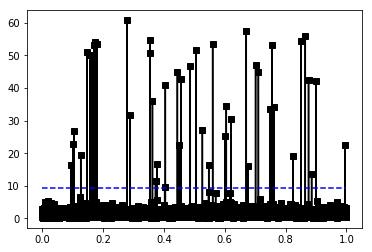

In [22]:
## signal is log-normal noise
N = 10000
time = np.arange(0,N)/N
signal1 = np.exp( .5*np.random.randn(N) )

# add some random outiers
nOutliers = 50
randpnts = np.random.randint(0,N,nOutliers)
signal1[randpnts] = np.random.rand(nOutliers) * (np.max(signal1)-np.min(signal1))*10

# show the signal
plt.plot(time,signal1,'ks-')

# auto-threshold based on mean and standard deviation
threshold = np.mean(signal1) + 3*np.std(signal1)
plt.plot([time[0],time[-1]],[threshold,threshold],'b--')
plt.show()

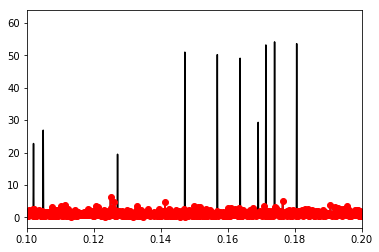

In [37]:
## interpolate outlier points


# remove supra-threshold points
outliers = signal1 > threshold

# and interpolate missing points
signalR = copy.deepcopy( signal1 )
signalR[outliers] = griddata(time[~outliers], signal1[~outliers], time[outliers], method='cubic')

# and plot the new results
plt.plot(time,signal1,'k-')
plt.plot(time,signalR,'ro-')

## optional zoom
plt.xlim([.1,.2])

plt.show()



---
# VIDEO: Outliers via local threshold exceedance
---


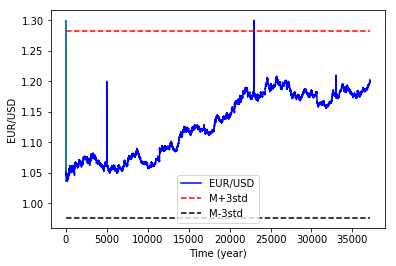

In [9]:
# data downloaded from:
# http://www.histdata.com/download-free-forex-historical-data/?/ascii/1-minute-bar-quotes/eurusd/2017

# import data, etc.
matdat = sio.loadmat('forex.mat')
forex  = np.squeeze(matdat['forex'])

N = len(forex)
time = np.arange(0,N)/N


# plot it
plt.plot(time,forex)
plt.xlabel('Time (year)')
plt.ylabel('EUR/USD')

# add global thresholds
threshup = np.mean(forex)+3*np.std(forex)
threshdn = np.mean(forex)-3*np.std(forex)
plt.plot(range(0,N),forex,'b',label='EUR/USD')
plt.plot([0,N],[threshup,threshup],'r--',label='M+3std')
plt.plot([0,N],[threshdn,threshdn],'k--',label='M-3std')
plt.legend()
plt.show()

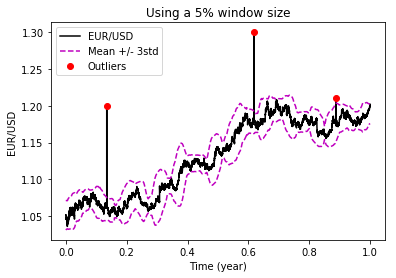

In [27]:
## local threshold

# window size as percent of total signal length
pct_win = 5 # in percent, not proportion!

# convert to indices
k = int(len(forex) * (pct_win/2/100))

# # initialize statistics time series to be the global stats
# mean_ts = np.ones(len(time)) * np.mean(forex)
# std3_ts = np.ones(len(time)) * np.std(forex)


# # loop over time points
# for i in range(0,N):
    
#     # boundaries
#     lo_bnd = np.max((0,i-k))
#     hi_bnd = np.min((i+k,N))
    
#     # compute local mean and std
#     mean_ts[i] =  np.mean( forex[range(lo_bnd,hi_bnd)] )
#     std3_ts[i] = 3*np.std( forex[range(lo_bnd,hi_bnd)] )




## compute local outliers 
outliers = (forex > mean_ts+std3_ts) | (forex < mean_ts-std3_ts)


# plotting...
plt.plot(time,forex,'k',label='EUR/USD')
plt.plot(time,mean_ts+std3_ts,'m--',label='Mean +/- 3std')
plt.plot(time,mean_ts-std3_ts,'m--')

# and plot those
plt.plot(time[outliers],forex[outliers],'ro',label='Outliers')

plt.legend()
plt.xlabel('Time (year)')
plt.ylabel('EUR/USD')
plt.title('Using a %d%% window size' %pct_win)
plt.show()


---
# VIDEO: Outlier time windows via sliding RMS
---


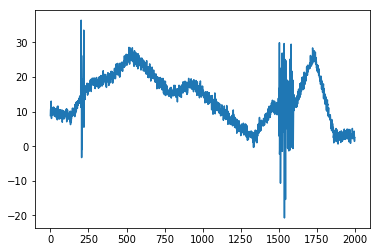

In [36]:
## generate signal with varying variability
n = 2000
p = 15  # poles for random interpolation

# amplitude modulator
signal1 = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
signal1 = signal1 + np.random.randn(n)


# add some high-amplitude noise
signal1[200:221]   = signal1[200:221] + np.random.randn(21)*9
signal1[1500:1601] = signal1[1500:1601] + np.random.randn(101)*9


# plot
plt.plot(signal1)
plt.show()


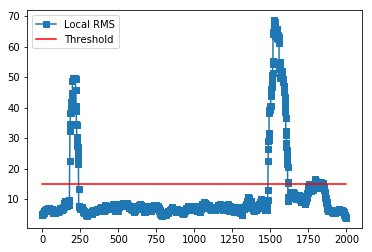

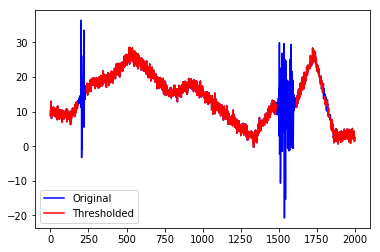

In [47]:
## detect bad segments using sliding RMS

# window size as percent of total signal length
pct_win = 2  # in percent, not proportion!

# convert to indices
k = int(n * (pct_win/2/100))

# initialize RMS time series vector
rms_ts = np.zeros(n)

for ti in range(0,n):
    
    # boundary points
    low_bnd = int( np.max((0,ti-k)) )
    upp_bnd = int( np.min((n,ti+k)) )
    
    # signal segment (and mean-center!)
    tmpsig = signal1[range(low_bnd,upp_bnd)]
    tmpsig = tmpsig - np.mean(tmpsig)
    
    # compute RMS in this window
    rms_ts[ti] = np.sqrt(np.sum( tmpsig**2 ))



# plot RMS
plt.plot(rms_ts,'s-',label='Local RMS')


# pick threshold manually based on visual inspection
thresh = 15
plt.plot([0,n],[thresh,thresh],'r',label='Threshold')
plt.legend()
plt.show()



# mark bad regions in original time series
signalR = copy.deepcopy( signal1 )
signalR[ rms_ts>thresh ] = np.nan


plt.plot(signal1,'b',label='Original')
plt.plot(signalR,'r',label='Thresholded')
plt.legend()
plt.show()